In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import display, HTML
from pyspark import StorageLevel
from pyspark.sql import SparkSession
from sedona.register import SedonaRegistrator
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
import geopandas as gpd
from sedona.utils.adapter import Adapter
from sedona.core.formatMapper.shapefileParser import ShapefileReader

In [2]:
spark = SparkSession.\
    builder.\
    master("local[*]").\
    appName("Sedona App").\
    config("spark.serializer", KryoSerializer.getName).\
    config("spark.kryo.registrator", SedonaKryoRegistrator.getName).\
    config("spark.jars.packages", "org.apache.sedona:sedona-python-adapter-3.0_2.12:1.2.0-incubating,org.datasyslab:geotools-wrapper:geotools-24.0").\
    getOrCreate()

22/08/29 18:57:42 WARN Utils: Your hostname, EN4102944L resolves to a loopback address: 127.0.1.1; using 10.218.105.94 instead (on interface eno1)
22/08/29 18:57:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /home/local/ASUAD/kchowdh1/.ivy2/cache
The jars for the packages stored in: /home/local/ASUAD/kchowdh1/.ivy2/jars
:: loading settings :: url = jar:file:/media/kchowdh1/fcf87b53-9c62-4c1d-9df2-cb2b83598bea/kanchan/program_files/spark-3.0.3-bin-hadoop2.7/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
org.apache.sedona#sedona-python-adapter-3.0_2.12 added as a dependency
org.datasyslab#geotools-wrapper added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-619b8c59-7498-43e3-82a9-b8104832a4d1;1.0
	confs: [default]
	found org.apache.sedona#sedona-python-adapter-3.0_2.12;1.2.0-incubating in central
	found org.locationtech.jts#jts-core;1.18.0 in central
	found org.wololo#jts2geojson;0.

In [3]:
SedonaRegistrator.registerAll(spark)

True

In [4]:
sc = spark.sparkContext
sc.setSystemProperty("sedona.global.charset", "utf8")

## Load Taxi Trips Shape File

In [5]:
taxi_zones = gpd.read_file("data/taxi_trip/taxi_zones")

In [6]:
taxi_zones.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14..."


In [7]:
print(taxi_zones.crs)

epsg:2263


<AxesSubplot:>

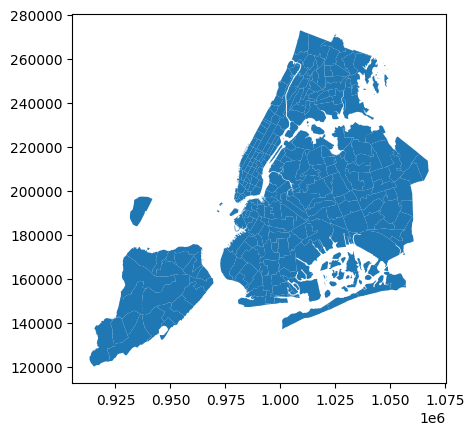

In [8]:
taxi_zones.plot()

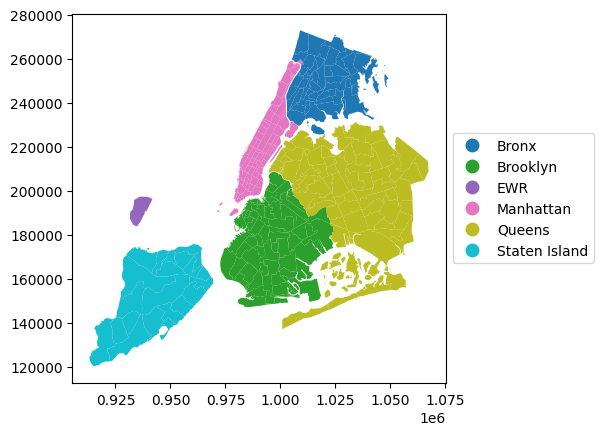

In [9]:
ax = taxi_zones.plot(column='borough', categorical=True, legend=True, legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5)})

In [ ]:
taxi_zones = taxi_zones.drop(['Shape_Leng', 'Shape_Area', 'LocationID'], axis=1)

In [ ]:
taxi_zones.head()

In [10]:
taxi_zones_aggregated = taxi_zones.dissolve(by = 'borough')

<AxesSubplot:>

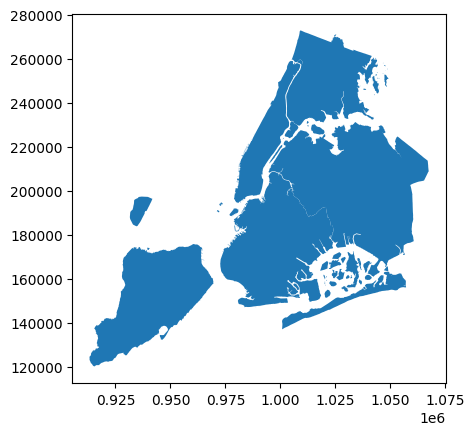

In [11]:
taxi_zones_aggregated.plot()

<AxesSubplot:>

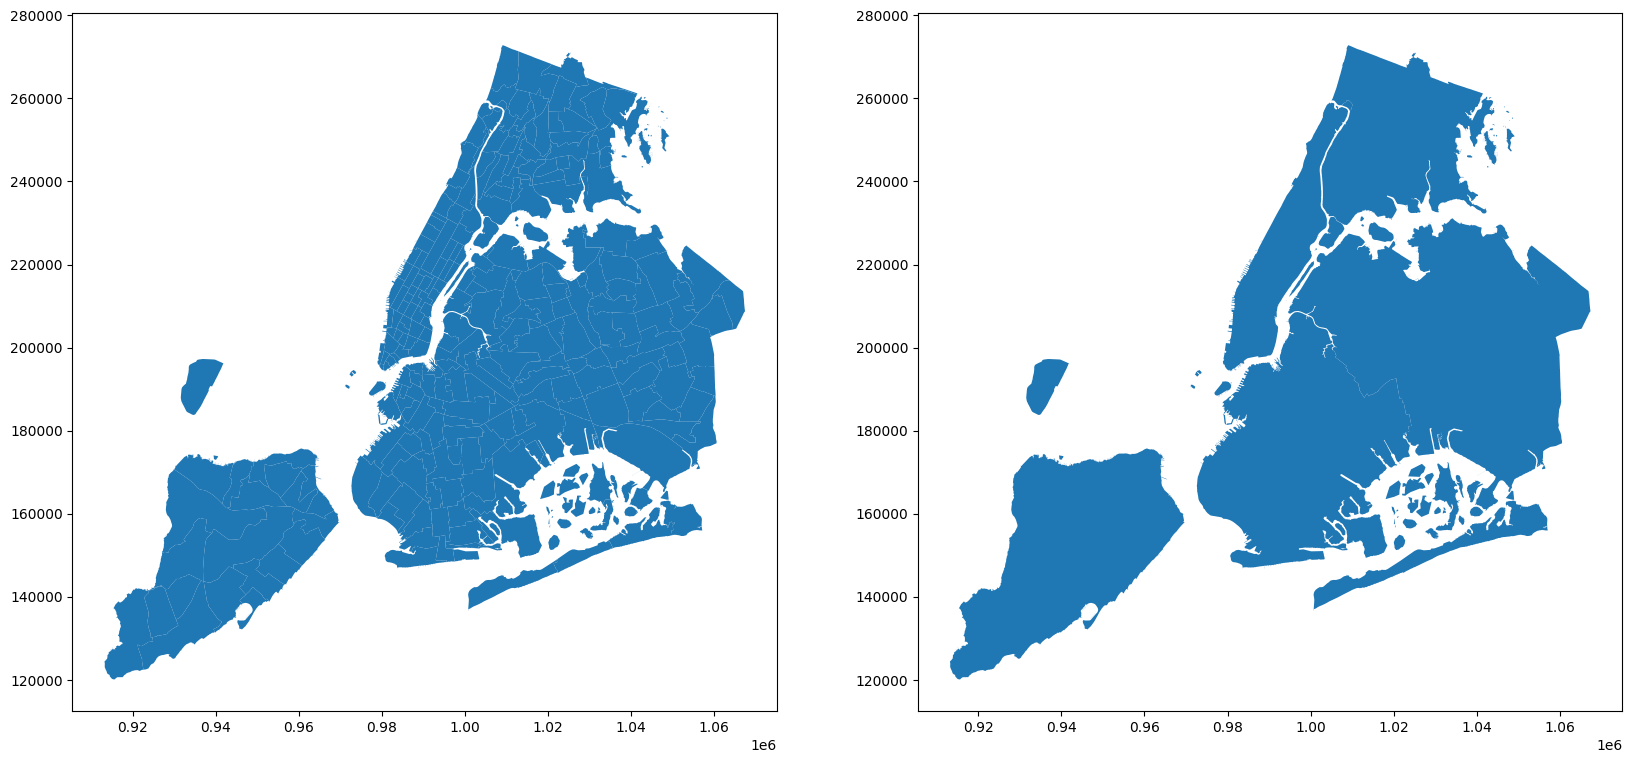

In [12]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 16))
taxi_zones.plot(ax=ax1)
taxi_zones_aggregated.plot(ax=ax2)

In [13]:
taxi_zone_rdd = ShapefileReader.readToGeometryRDD(sc, "data/taxi_trip/taxi_zones")

In [14]:
taxi_zone_df = Adapter.toDf(taxi_zone_rdd, spark)

In [15]:
taxi_zone_df.printSchema()

root
 |-- geometry: geometry (nullable = true)
 |-- OBJECTID: string (nullable = true)
 |-- Shape_Leng: string (nullable = true)
 |-- Shape_Area: string (nullable = true)
 |-- zone: string (nullable = true)
 |-- LocationID: string (nullable = true)
 |-- borough: string (nullable = true)



In [16]:
taxi_zone_df.show(5)

+--------------------+---------+-------------------+-------------------+--------------------+----------+--------------------+
|            geometry| OBJECTID|         Shape_Leng|         Shape_Area|                zone|LocationID|             borough|
+--------------------+---------+-------------------+-------------------+--------------------+----------+--------------------+
|POLYGON ((933100....|        1| 1.16357453189e-001| 7.82306788500e-004|Newark Airport   ...|         1|EWR              ...|
|MULTIPOLYGON (((1...|        2| 4.33469666790e-001| 4.86634037837e-003|Jamaica Bay      ...|         2|Queens           ...|
|POLYGON ((1026308...|        3| 8.43411059012e-002| 3.14414156821e-004|Allerton/Pelham G...|         3|Bronx            ...|
|POLYGON ((992073....|        4| 4.35665270921e-002| 1.11871946192e-004|Alphabet City    ...|         4|Manhattan        ...|
|POLYGON ((935843....|        5| 9.21464898574e-002| 4.97957489363e-004|Arden Heights    ...|         5|Staten Island 

<AxesSubplot:>

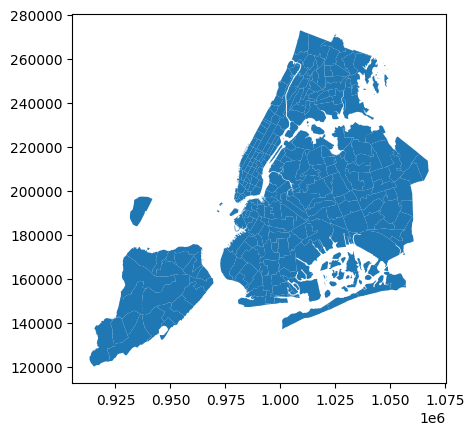

In [17]:
taxi_zone_gdf = gpd.GeoDataFrame(taxi_zone_df.toPandas(), geometry = "geometry")
taxi_zone_gdf.plot()

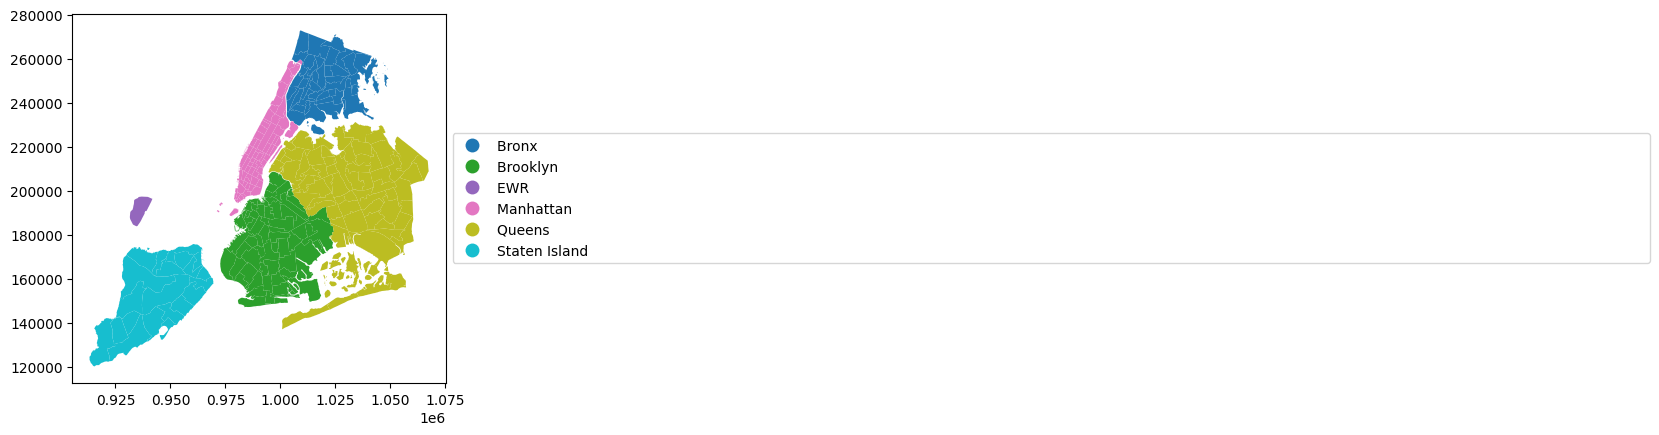

In [18]:
ax = taxi_zone_gdf.plot(column='borough', categorical=True, legend=True, legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5)})

## Load GeoTIFF Files

In [19]:
# Path to directory of geotiff images 
DATA_DIR = "data/raster"

In [20]:
df = spark.read.format("geotiff").option("dropInvalid",True).option("readToCRS", "EPSG:4326").option("disableErrorInCRS", False).load(DATA_DIR)
df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- geometry: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nBands: integer (nullable = true)
 |    |-- data: array (nullable = true)
 |    |    |-- element: double (containsNull = true)



In [21]:
df.show()

+--------------------+
|               image|
+--------------------+
|[file:///media/kc...|
|[file:///media/kc...|
+--------------------+



In [22]:
df2 = df.selectExpr("image.origin as origin","ST_GeomFromWkt(image.geometry) as Geom", "image.height as height", "image.width as width", "image.data as data", "image.nBands as bands")
df2.show()

+--------------------+--------------------+------+-----+--------------------+-----+
|              origin|                Geom|height|width|                data|bands|
+--------------------+--------------------+------+-----+--------------------+-----+
|file:///media/kch...|POLYGON ((-58.702...|    32|   32|[1081.0, 1068.0, ...|    4|
|file:///media/kch...|POLYGON ((-58.286...|    32|   32|[1151.0, 1141.0, ...|    4|
+--------------------+--------------------+------+-----+--------------------+-----+

